# Лабораторная работа №4

**Тема: "Шум"**

Работу выполнил

студент группы 5130901/20201

Нестеренко Сергей Андреевич

---

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import normalize, unbias, read_wave, PinkNoise, decorate, UncorrelatedGaussianNoise, Spectrum, Wave, Noise
import numpy as np

## Упражнение 4.1

С сайта freesound.org скачаем несколько аудиозаписей, содержащих примеры естественных источников шума:
1. Звуки горения костра
2. Шум океана
3. Звуки дождя

In [2]:
wave1 = read_wave(filename='./audio/bonfire-flames.wav').segment(start=2, duration=1)
wave2 = read_wave(filename='./audio/ocean-crete.wav').segment(start=2, duration=4)
wave3 = read_wave(filename='./audio/rain-and-thunder.wav').segment(start=2, duration=1)

### 1. Шум костра

In [3]:
wave1.make_audio()

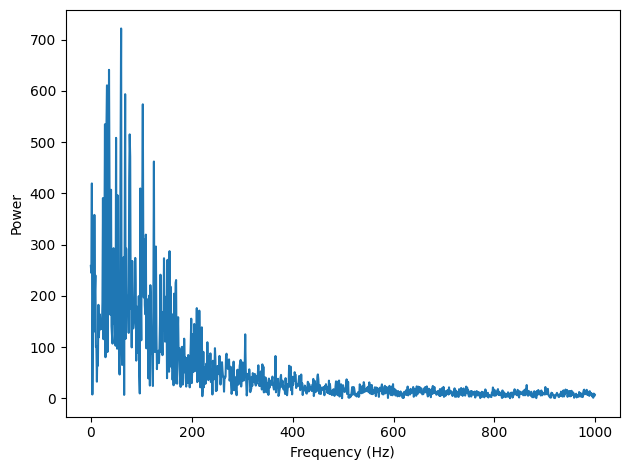

In [4]:
wave1.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

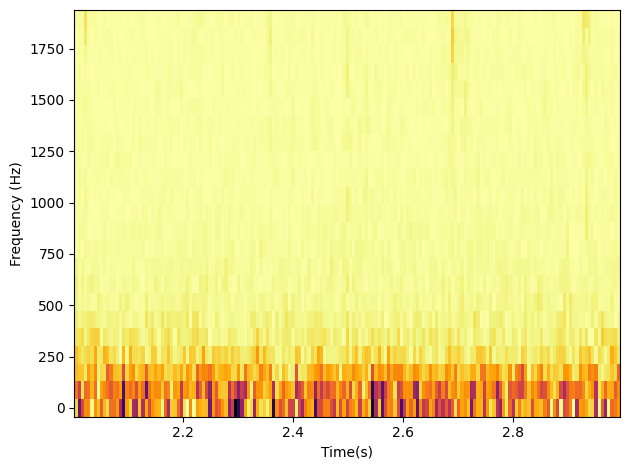

In [5]:
wave1.make_spectrogram(512).plot(high=2000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Этот шум напоминает розовый за счет того, что при увеличении частоты резко уменьшается амплитуда. Из спектрограммы видно, что высота тона не "блуждает", как в случае броуновского шума.

Для сравнения ниже приведены характеристики розового шума с бета=1,0.

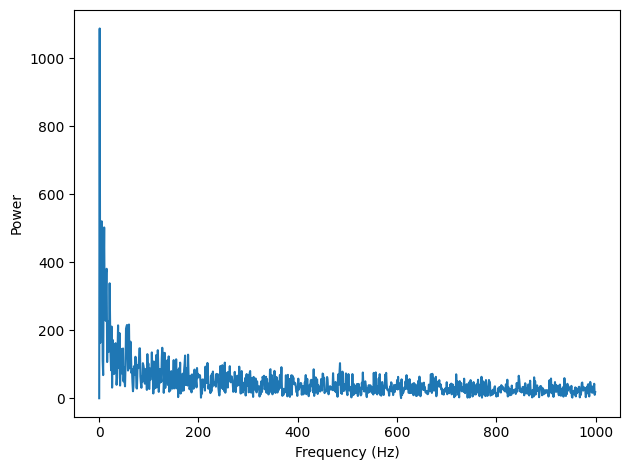

In [6]:
pink = PinkNoise(amp=1.0, beta=1.0).make_wave(duration=1)
pink.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

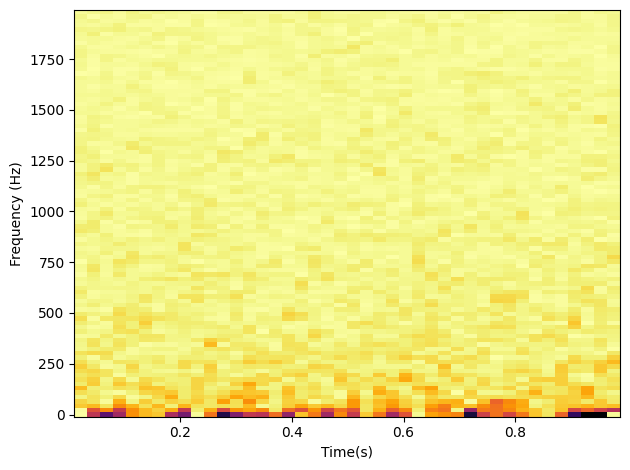

In [7]:
pink.make_spectrogram(512).plot(high=2000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

### 2. Шум океана

In [8]:
wave2.make_audio()

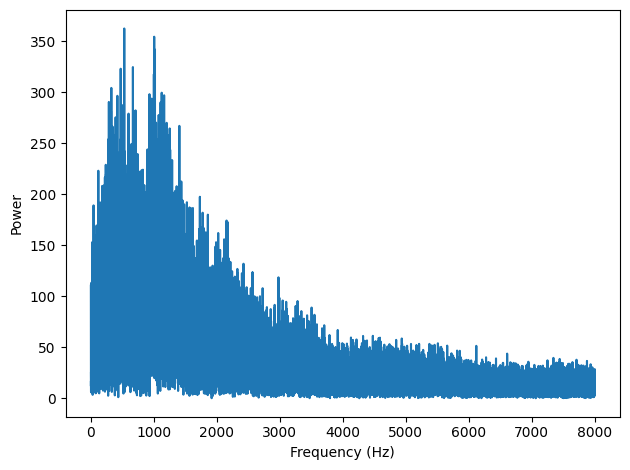

In [9]:
wave2.make_spectrum().plot(high=8000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

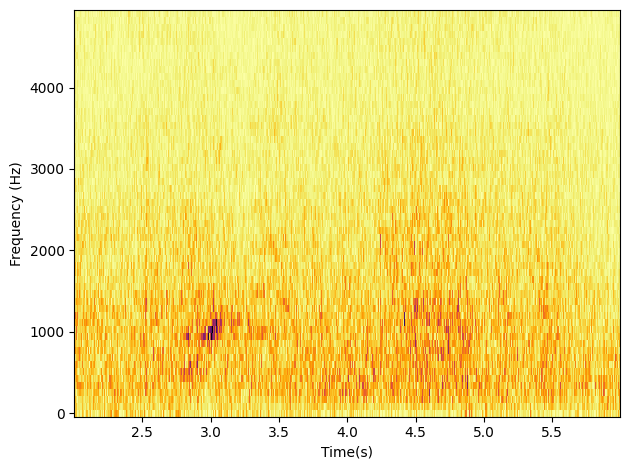

In [10]:
wave2.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Данный шум тоже напоминает розовый, однако с гораздо менее крутым пиком на низких частотах. Его частоты распределены ближе к равномерному, но он не является UU-шумом. Также его нельзя назвать UG-шумом (его спектр приведен ниже). Броуновского "блуждания" также на наблюдается. Таким образом, данный шум нельзя назвать ни белым, ни розовым, ни броуновским.

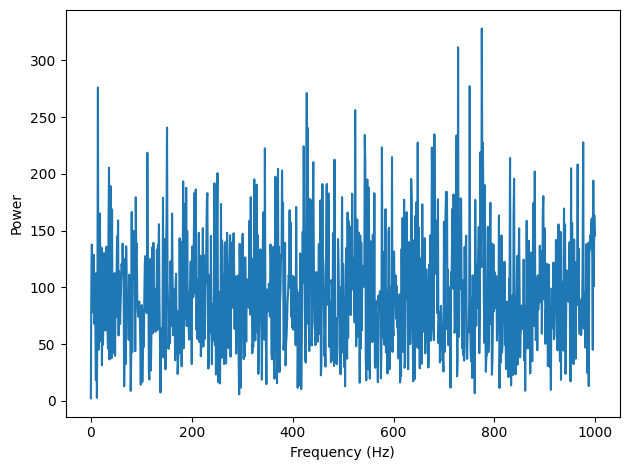

In [11]:
ug = UncorrelatedGaussianNoise(amp=1.0).make_wave(duration=1)
ug.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

### 3. Шум дождя

In [12]:
wave3.make_audio()

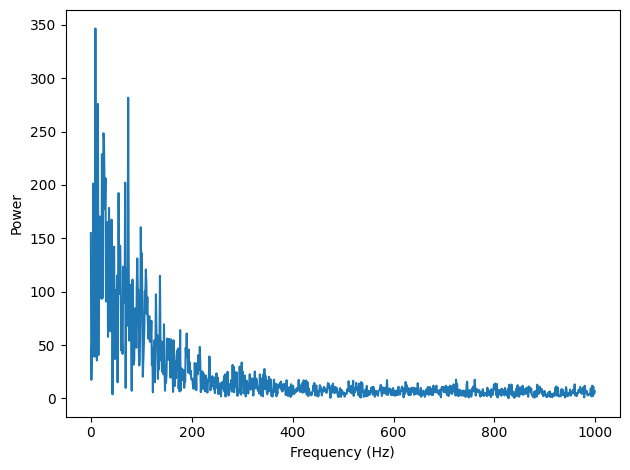

In [13]:
wave3.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

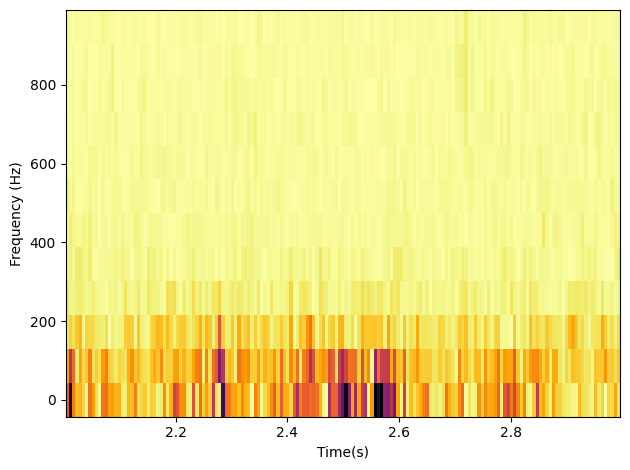

In [14]:
wave3.make_spectrogram(512).plot(high=1000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Данный шум похож на розовый, как и в первом примере.

## Упражнение 4.2

Реализуем метод Бартлетта. Для этого воспользуемся функцией `make_spectrogram` и достанем из неё уже готовые значения спектров для каждого сегмента.

In [15]:
def bartlett(wave, seg_length=512, win_flag=True):
    spectrogram = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectrogram.spec_map.values()
    psds = [spectrum.power for spectrum in spectrums]
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    return Spectrum(hs, fs, wave.framerate)

Применим метод Бартлетта для оценки спектра мощности шума океана.

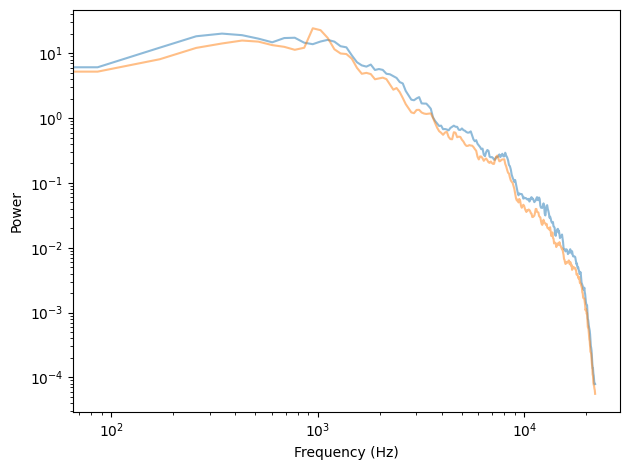

In [16]:
bartlett(wave2.segment(start=0, duration=1.9)).plot_power(alpha=0.5)
bartlett(wave2.segment(start=2, duration=1.9)).plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

Из графика видно, что средние значения спектра на двух соседних сегментах записи имеют схожую форму и лишь незначительно отклоняются.

## Упражнение 4.3

По ссылке https://github.com/Habrador/Bitcoin-price-visualization/blob/main/Bitcoin-price-USD.csv доступна информация о стоимости валюты Bitcoin с 2010 по 2024 год.

In [17]:
import pandas as pd

df = pd.read_csv('./csv/Bitcoin-price-USD.csv')
df

,Date,Price
0,2010-07-18,0.090000
1,2010-07-19,0.080000
2,2010-07-20,0.070000
3,2010-07-21,0.080000
4,2010-07-22,0.050000
...,...,...
5134,2024-08-07,55027.460938
5135,2024-08-08,61710.136719
5136,2024-08-09,60880.113281
5137,2024-08-10,60945.812500


Построим график валюты по дням.

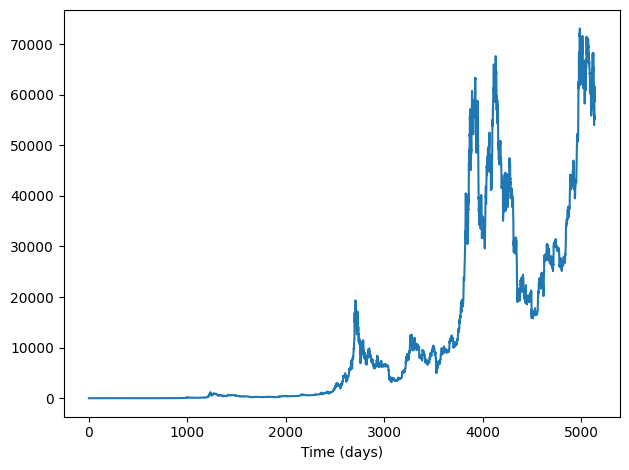

In [18]:
btc = Wave(
    ys=df['Price'],
    ts=df.index,
    framerate=1,
)
btc.plot()
decorate(xlabel='Time (days)')

Также можем построить спектр.

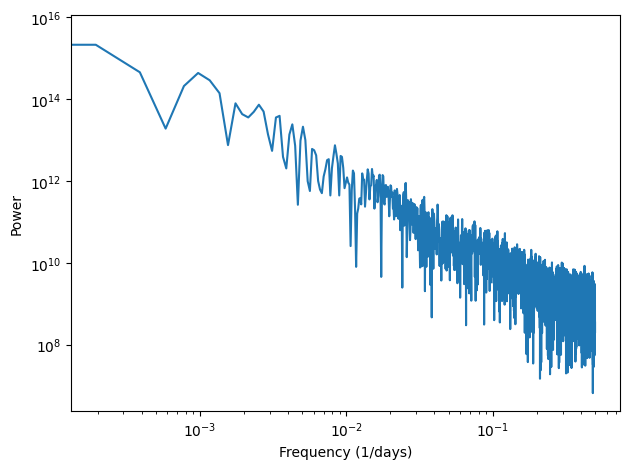

In [19]:
btc_spectrum = btc.make_spectrum() 
btc_spectrum.plot_power()
decorate(xlabel='Frequency (1/days)', ylabel='Power', xscale='log', yscale='log')

In [20]:
btc_spectrum.estimate_slope()[0]

np.float64(-1.8141987193262035)

Похожий результат получится, если построить спектр розового шума с beta=1.814

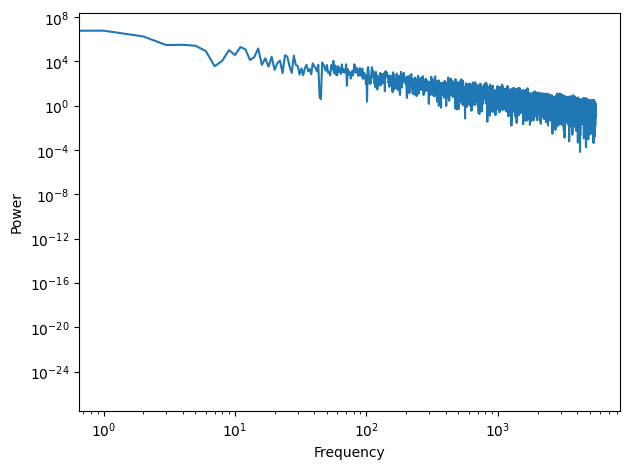

In [21]:
PinkNoise(beta=1.814).make_wave().make_spectrum().plot_power()
decorate(xlabel='Frequency', ylabel='Power', xscale='log', yscale='log')

## Упражнение 4.4

Создадим класс `UncorrelatedPoissonNoise`, наследующий `Noise` и предоставляющий `evaluate`.

In [22]:
class UncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Сгенерируем сигнал с небольшой амплитудой и прослушаем. Результат звучит очень похоже на настоящий счетчик Гейгера.

In [23]:
fish1 = UncorrelatedPoissonNoise(amp=0.001).make_wave(duration=2, framerate=10000)
fish1.make_audio()

Если сделать амплитуду достаточно большой, получается что-то похожее на белый шум.

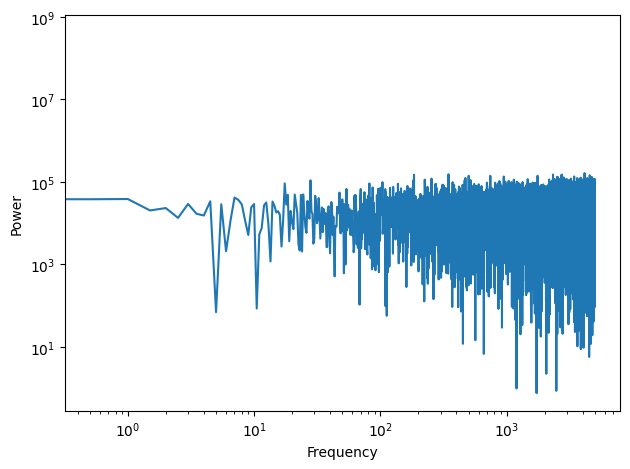

In [24]:
fish2 = UncorrelatedPoissonNoise(amp=1).make_wave(duration=2, framerate=10000)
fish2.make_spectrum().plot_power()
decorate(xlabel='Frequency', ylabel='Power', xscale='log', yscale='log')
fish2.make_audio()

## Упражнение 4.5

Реализуем генерацию розового шума на основе алгоритма Voss-McCartney. Он заключается в том, что последовательность случайных чисел суммируется с другими последовательностями, частота дискретизации которых каждый раз уменьшается вдвое по отношению к предыдущей.

In [25]:
def voss(nrows, ncols=16):
    matrix = np.empty((nrows, ncols))
    matrix.fill(np.nan)
    matrix[0, :] = np.random.random(ncols)
    matrix[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    matrix[rows, cols] = np.random.random(n)

    df = pd.DataFrame(matrix)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

Сгенерируем сигнал на основе полученной функции.

In [26]:
ys = voss(10000)
wave = Wave(ys=ys, framerate=10000)
wave.unbias()
wave.normalize()

wave.make_audio()

C:\Users\zeovl\AppData\Local\Temp\ipykernel_11324\662244743.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


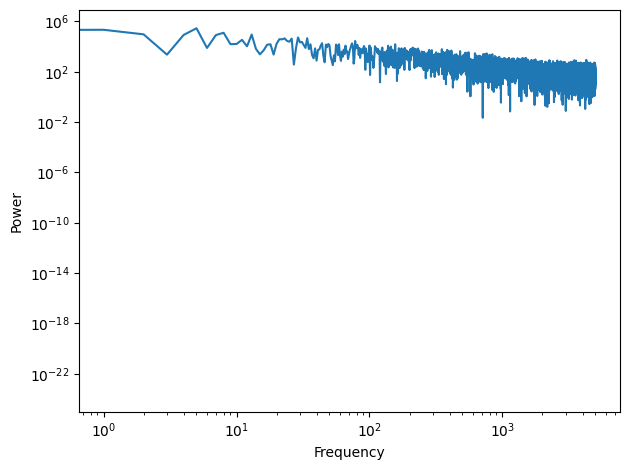

In [27]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency', ylabel='Power', xscale='log', yscale='log')

In [28]:
spectrum.estimate_slope().slope

np.float64(-0.9800390498450261)

Полученный шум действительно является розовым.